In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Homework part I: Prohibited Comment Classification (3 points)

![img](https://github.com/yandexdataschool/nlp_course/raw/master/resources/banhammer.jpg)

__In this notebook__ you will build an algorithm that classifies social media comments into normal or toxic.
Like in many real-world cases, you only have a small (10^3) dataset of hand-labeled examples to work with. We'll tackle this problem using both classical nlp methods and embedding-based approach.

In [2]:
import pandas as pd
data = pd.read_csv("comments.tsv", sep='\t')

texts = data['comment_text'].values
target = data['should_ban'].values
data[50::200]

,should_ban,comment_text
50,0,"""Those who're in advantageous positions are th..."
250,1,Fartsalot56 says f**k you motherclucker!!
450,1,"Are you a fool? \n\nI am sorry, but you seem t..."
650,1,I AM NOT A VANDAL!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
850,0,Citing sources\n\nCheck out the Wikipedia:Citi...


In [3]:
from sklearn.model_selection import train_test_split
texts_train, texts_test, y_train, y_test = train_test_split(texts, target, test_size=0.5, random_state=42)

__Note:__ it is generally a good idea to split data into train/test before anything is done to them.

It guards you against possible data leakage in the preprocessing stage. For example, should you decide to select words present in obscene tweets as features, you should only count those words over the training set. Otherwise your algoritm can cheat evaluation.

### Preprocessing and tokenization

Comments contain raw text with punctuation, upper/lowercase letters and even newline symbols.

To simplify all further steps, we'll split text into space-separated tokens using one of nltk tokenizers.

In [4]:
from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer()
preprocess = lambda text: ' '.join(tokenizer.tokenize(text)).lower()

text = 'How to be a grown-up at work: replace "fuck you" with "Ok, great!".'
print("before:", text,)
print("after:", preprocess(text),)

before: How to be a grown-up at work: replace "fuck you" with "Ok, great!".
after: how to be a grown-up at work : replace " fuck you " with " ok , great ! " .


In [5]:
# task: preprocess each comment in train and test
vectorized_preprocess_func = np.vectorize(preprocess)

texts_train = vectorized_preprocess_func(texts_train)
texts_test = vectorized_preprocess_func(texts_test)

In [6]:
assert texts_train[5] ==  'who cares anymore . they attack with impunity .'
assert texts_test[89] == 'hey todds ! quick q ? why are you so gay'
assert len(texts_test) == len(y_test)

### Solving it: bag of words

![img](http://www.novuslight.com/uploads/n/BagofWords.jpg)

One traditional approach to such problem is to use bag of words features:
1. build a vocabulary of frequent words (use train data only)
2. for each training sample, count the number of times a word occurs in it (for each word in vocabulary).
3. consider this count a feature for some classifier

__Note:__ in practice, you can compute such features using sklearn. Please don't do that in the current assignment, though.
* `from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer`

In [7]:
from collections import Counter

# task: find up to k most frequent tokens in texts_train,
# sort them by number of occurences (highest first)
k = 10000

counter = Counter()
for text in texts_train:
  for word in text.split():
    counter[word] += 1

bow_vocabulary = [key for key, value in counter.most_common(k)]
print('example features:', sorted(bow_vocabulary)[::100])

example features: ['!', '12:20', '300', '_', 'adorned', 'alternative', 'archive', 'average', 'benkner', 'bout', 'came', 'chest', 'combined', 'consumers', 'cricket', 'decisions', 'dickheads', 'domestic', 'eductaion', 'essentially', 'faggot', 'firms', 'frustrated', 'goal', 'hanibal', 'hip-hop', 'identified', 'infoboxes', 'issue', 'kindergarten', 'lets', 'lot', "mclaren's", 'moderator', 'naturally', 'noticeable', 'opposing', 'pdf', 'plant', 'pretoria', 'punctuation', 'rebels', 'repetative', 'riadh', 'schulz', 'shes', 'slit', 'spoof', 'stupid', 't', 'theoretical', 'topic', 'uglyness', 'userspace', 'wanted', 'wikieditor', 'year', '←']


In [8]:
max_len = 0

for text in texts_train:
  max_len = max(max_len, len(text.split()))
for text in texts_test:
  max_len = max(max_len, len(text.split()))
max_len

1247

In [9]:
len(bow_vocabulary)

5707

In [10]:
count_of_occures = {k: v for k, v in counter.most_common(k)}
count_of_occures['the']

1219

In [11]:
# так как размерность везде разная, то будем паддить до min(k, k_max) и трункейтить так же

In [12]:
k_max = len(set(' '.join(texts_train).split()))
max_len = min(k, k_max)
max_len

5707

In [13]:
k_max = len(set(' '.join(texts_train).split()))
max_len = min(k, k_max)


def text_to_bow(text):
    """ convert text string to an array of token counts. Use bow_vocabulary. """
    arr = [0] * max_len
    for word in text.split():
      if word in bow_vocabulary:
        arr[bow_vocabulary.index(word)] += 1

    return np.array(arr, 'float32')

In [14]:
X_train_bow = np.stack(list(map(text_to_bow, texts_train)))
X_test_bow = np.stack(list(map(text_to_bow, texts_test)))

In [15]:
k_max = len(set(' '.join(texts_train).split()))
assert X_train_bow.shape == (len(texts_train), min(k, k_max))
assert X_test_bow.shape == (len(texts_test), min(k, k_max))
assert np.all(X_train_bow[5:10].sum(-1) == np.array([len(s.split()) for s in  texts_train[5:10]]))
assert len(bow_vocabulary) <= min(k, k_max)
assert X_train_bow[6, bow_vocabulary.index('.')] == texts_train[6].split().count('.')

__Naive bayes:__ perhaps the simplest model that can solve your problem is the so called Naive Bayes Classifier.
Its a trivial linear model that assumes the independence of input features and computes the coefficients by, well, counting probabilities.

If you don't remember the math behind Naive Bayes, read [this chunk](https://lena-voita.github.io/nlp_course/text_classification.html#naive_bayes) to help refresh your memory. Done? Good! Now let's implement that :)

In [16]:
class BinaryNaiveBayes:
    delta = 1.0  # add this to all word counts to smoothe probabilities

    def fit(self, X, y):
        """
        Fit a NaiveBayes classifier for two classes
        :param X: [batch_size, vocab_size] of bag-of-words features
        :param y: [batch_size] of binary targets {0, 1}
        """
        n_samples, vocab_size = X.shape

        # считаем вероятности для меток классов
        self.p_y = np.array([np.mean(y == 0), np.mean(y == 1)])

        # считаем встречаемость каждого слова по классам
        word_counts_positive = np.sum(X[y == 1], axis=0)
        word_counts_negative = np.sum(X[y == 0], axis=0)
        # ^-- both must be vectors of shape [vocab_size].

        # finally, lets use those counts to estimate p(x | y = k) for k = 0, 1

        # Применяем сглаживание и считаем условные вероятности слов
        self.p_x_given_positive = (word_counts_positive + self.delta) \
                      / (np.sum(word_counts_positive) + vocab_size * self.delta)
        self.p_x_given_negative = (word_counts_negative + self.delta) \
                      / (np.sum(word_counts_negative) + vocab_size * self.delta)
        # both must be of shape [vocab_size]; and don't forget to add self.delta!

        return self

    def predict_scores(self, X):
        """
        :param X: [batch_size, vocab_size] of bag-of-words features
        :returns: a matrix of scores [batch_size, k] of scores for k-th class
        """
        # compute scores for positive and negative classes separately.
        # these scores should be proportional to log-probabilities of the respective target {0, 1}
        # note: if you apply logarithm to p_x_given_*, the total log-probability can be written
        # as a dot-product with X

        # логарифмирование вероятностей для упрощения вычисления
        log_p_x_given_positive = np.log(self.p_x_given_positive)
        log_p_x_given_negative = np.log(self.p_x_given_negative)

        score_negative = X @ log_p_x_given_negative + np.log(self.p_y[0])
        score_positive = X @ log_p_x_given_positive + np.log(self.p_y[1])

        # возвращаем нормализованные логарифмические вероятности
        return np.stack([score_negative, score_positive], axis=-1)

    def predict(self, X):
        scores = self.predict_scores(X)
        return np.argmax(scores, axis=-1)

In [17]:
naive_model = BinaryNaiveBayes().fit(X_train_bow, y_train)

In [18]:
assert naive_model.p_y.shape == (2,) and naive_model.p_y.sum() == 1 and naive_model.p_y[0] > naive_model.p_y[1]
assert naive_model.p_x_given_positive.shape == naive_model.p_x_given_negative.shape == X_train_bow.shape[1:]
assert np.allclose(naive_model.p_x_given_positive.sum(), 1.0)
assert np.allclose(naive_model.p_x_given_negative.sum(), 1.0)
assert naive_model.p_x_given_negative.min() > 0, "did you forget to add delta?"

f_index = bow_vocabulary.index('fuck')  # offensive tweets should contain more of this
assert naive_model.p_x_given_positive[f_index] > naive_model.p_x_given_negative[f_index]

g_index = bow_vocabulary.index('good')  # offensive tweets should contain less of this
assert naive_model.p_x_given_positive[g_index] < naive_model.p_x_given_negative[g_index]

Model accuracy: 0.756
Well done!


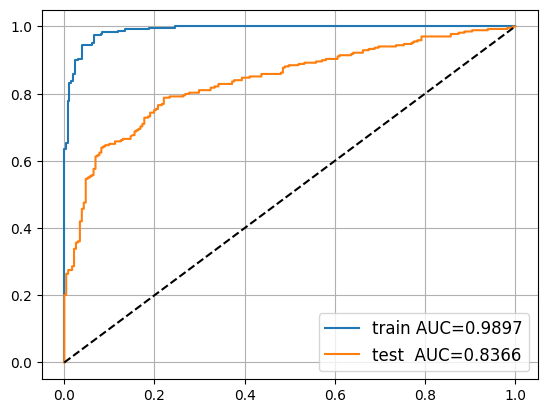

In [19]:
from sklearn.metrics import roc_auc_score, roc_curve

for name, X, y, model in [
    ('train', X_train_bow, y_train, naive_model),
    ('test ', X_test_bow, y_test, naive_model)
]:
    proba = model.predict_scores(X)[:, 1] - model.predict_scores(X)[:, 0]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

test_accuracy = np.mean(naive_model.predict(X_test_bow) == y_test)
print(f"Model accuracy: {test_accuracy:.3f}")
assert test_accuracy > 0.75, "Accuracy too low. There's likely a mistake in the code."
print("Well done!")

Okay, it definitely learned *something*. Now let's figure out what exactly it learned. The simplest way to do that is by highlighting which words have a greatest ratio of positive to negative probability or vice versa. We'll go with the positive one [because reasons](https://www.urbandictionary.com/define.php?term=because%20reasons).

__Your task__ is to compute top-25 words that have the __highest__ ratio of ${p(x_i | y=1)} \over {p(x_i | y=0)}$. Enjoy!

In [20]:
# hint: use naive_model.p_*
probability_ratio = naive_model.p_x_given_positive / naive_model.p_x_given_negative
top_indices = probability_ratio.argsort()[-25:]
top_negative_words = [bow_vocabulary[index] for index in top_indices]

assert len(top_negative_words) == 25 and [isinstance(w, str) for w in top_negative_words]
assert 'j.delanoy' in top_negative_words and 'college' in top_negative_words

for i, word in enumerate(top_negative_words):
    print(f"#{i}\t{word.rjust(10, ' ')}\t(ratio={probability_ratio[bow_vocabulary.index(word)]})")

#0	scientific	(ratio=12.222967147827148)
#1	         @	(ratio=13.445263862609863)
#2	     idiot	(ratio=13.445263862609863)
#3	   bastard	(ratio=14.667561531066895)
#4	       hit	(ratio=14.667561531066895)
#5	         u	(ratio=15.278709411621094)
#6	   asshole	(ratio=15.889857292175293)
#7	         *	(ratio=17.11215591430664)
#8	   college	(ratio=17.11215591430664)
#9	         =	(ratio=17.53995704650879)
#10	    stupid	(ratio=18.33445167541504)
#11	       ass	(ratio=26.890527725219727)
#12	   fucking	(ratio=31.779714584350586)
#13	      slap	(ratio=44.002681732177734)
#14	      shit	(ratio=44.002681732177734)
#15	      fuck	(ratio=53.78105545043945)
#16	     bitch	(ratio=59.89254379272461)
#17	      fggt	(ratio=97.78373718261719)
#18	      dick	(ratio=187.0113983154297)
#19	 j.delanoy	(ratio=220.01341247558594)
#20	    nigger	(ratio=223.6802978515625)
#21	      suck	(ratio=314.7414245605469)
#22	   offfuck	(ratio=441.2491149902344)
#23	      heil	(ratio=471.8065185546875)
#24	    hitler

Now lets try something less prehistoric: __Logistic Regression__. Turns out, if you're using silicon instead of an abacus, you can find model weights by optimizing the log-probability of the answer. Though, of course, you don't even need to write it by hand anymore. Let's sklearn it!

In [21]:
from sklearn.linear_model import LogisticRegression

bow_model = LogisticRegression(C=0.2)
bow_model.fit(X_train_bow, y_train)

LogisticRegression(C=0.2)

Model accuracy: 0.772
Well done!


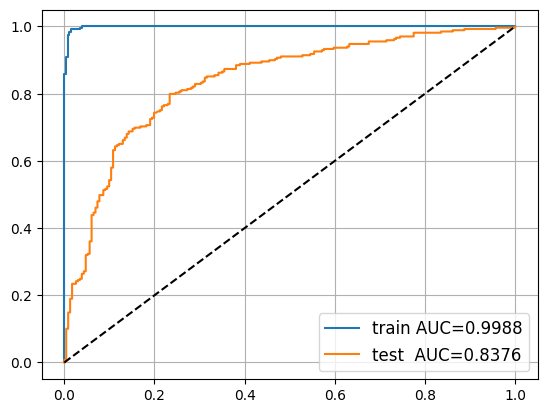

In [22]:
from sklearn.metrics import roc_auc_score, roc_curve

for name, X, y, model in [
    ('train', X_train_bow, y_train, bow_model),
    ('test ', X_test_bow, y_test, bow_model)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

test_accuracy = np.mean(bow_model.predict(X_test_bow) == y_test)
print(f"Model accuracy: {test_accuracy:.3f}")
assert test_accuracy > 0.77, "Hint: tune the parameter C to improve performance"
print("Well done!")

### Task: implement TF-IDF features

Not all words are equally useful. One can prioritize rare words and downscale words like "and"/"or" by using __tf-idf features__. This abbreviation stands for __text frequency/inverse document frequence__ and means exactly that:

$$ feature_i = { Count(word_i \in x) \times { log {N \over Count(word_i \in D) + \alpha} }} $$


, where x is a single text, D is your dataset (a collection of texts), N is a total number of documents and $\alpha$ is a smoothing hyperparameter (typically 1).
And $Count(word_i \in D)$ is the number of documents where $word_i$ appears.

It may also be a good idea to normalize each data sample after computing tf-idf features.

__Your task:__ implement tf-idf features, train a model and evaluate ROC curve. Compare it with basic BagOfWords model from above.

Please don't use sklearn/nltk builtin tf-idf vectorizers in your solution :) You can still use 'em for debugging though.

In [23]:
def tf_idf(text, dataset, alpha=1):
    features = []
    splitted_text = text.split()
    N = len(dataset)

    for word in splitted_text:
      if word not in bow_vocabulary:
        features.append(0)
        continue

      tf = splitted_text.count(word)

      count_doc_occur_word = count_of_occures[word]

      idf = np.log(N / (count_doc_occur_word + alpha))

      feature = tf * idf
      features.append(feature)

    return features

In [24]:
tfidf = []

for text in texts_train:
  print(text.split())
  tfidf.extend(tf_idf(text, texts_train))
  break

['...', 'oh', 'and', 'what', 'kind', 'of', 'person', 'watches', 'another', 'persons', 'mytalk', 'page', '?', 'stalker', '!']


In [25]:
tfidf # seems correct -> rare words feature is higher, often words feature is lower

[1.487220279709851,
 3.324236340526027,
 -0.35346981298978397,
 1.3547956940605195,
 3.4420193761824103,
 -0.24373018492259818,
 3.4420193761824103,
 5.521460917862246,
 3.123565645063876,
 4.268697949366878,
 5.521460917862246,
 1.3547956940605195,
 0.4748151862429575,
 4.828313737302301,
 -0.3421702577358507]

In [26]:
tfidf = []

for text in texts_train:
  print(text.split())
  tfidf.extend(tf_idf(text, texts_train))
  break

['...', 'oh', 'and', 'what', 'kind', 'of', 'person', 'watches', 'another', 'persons', 'mytalk', 'page', '?', 'stalker', '!']


In [27]:
X_train_bow.shape

(500, 5707)

In [28]:
X_train_bow[1]

array([9., 3., 1., ..., 0., 0., 0.], dtype=float32)

In [29]:
X_new_train_bow = X_train_bow.copy()

In [30]:
for text_idx, text in enumerate(texts_train):
  lst_of_tfidf_features = tf_idf(text, texts_train)
  for word_idx, word in enumerate(text.split()):
    X_new_train_bow[text_idx][bow_vocabulary.index(word)] = lst_of_tfidf_features[word_idx]

In [31]:
X_new_test_bow = X_test_bow.copy()

In [32]:
for text_idx, text in enumerate(texts_test):
  lst_of_tfidf_features = tf_idf(text, texts_test)
  for word_idx, word in enumerate(text.split()):
    if word not in bow_vocabulary:
      continue
    X_new_test_bow[text_idx][bow_vocabulary.index(word)] = lst_of_tfidf_features[word_idx]

In [33]:
print(X_new_train_bow[1])
print(X_new_test_bow[1])

[-9.971121  -3.0673528 -0.9880531 ...  0.         0.         0.       ]
[ 0.        -1.0224509  0.        ...  0.         0.         0.       ]


In [34]:
X_new_train_bow.shape, X_new_test_bow.shape

((500, 5707), (500, 5707))

In [35]:
from sklearn.linear_model import LogisticRegression

tfidf_model = LogisticRegression(C=0.1)
tfidf_model.fit(X_new_train_bow, y_train)

LogisticRegression(C=0.1)

Model accuracy: 0.786
Well done!


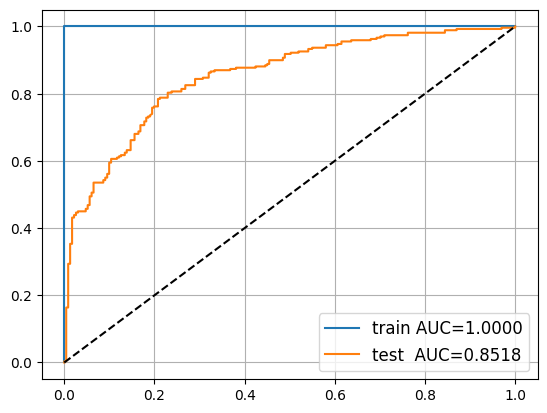

In [36]:
from sklearn.metrics import roc_auc_score, roc_curve

for name, X, y, model in [
    ('train', X_new_train_bow, y_train, tfidf_model),
    ('test ', X_new_test_bow, y_test, tfidf_model)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

test_accuracy = np.mean(tfidf_model.predict(X_new_test_bow) == y_test)
print(f"Model accuracy: {test_accuracy:.3f}")
assert test_accuracy > 0.77, "Hint: tune the parameter C to improve performance"
print("Well done!")

In [37]:
pip install catboost -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 9.4 MB/s eta 0:00:00


In [38]:
from catboost import CatBoostClassifier

tfidf_model = CatBoostClassifier()
tfidf_model.fit(X_new_train_bow, y_train)

Learning rate set to 0.007663
0:	learn: 0.6921563	total: 70.2ms	remaining: 1m 10s
1:	learn: 0.6902757	total: 89.7ms	remaining: 44.7s
2:	learn: 0.6887026	total: 112ms	remaining: 37.2s
3:	learn: 0.6874504	total: 138ms	remaining: 34.2s
4:	learn: 0.6860109	total: 156ms	remaining: 30.9s
5:	learn: 0.6846301	total: 174ms	remaining: 28.8s
6:	learn: 0.6822364	total: 196ms	remaining: 27.8s
7:	learn: 0.6802947	total: 217ms	remaining: 26.9s
8:	learn: 0.6790818	total: 235ms	remaining: 25.9s
9:	learn: 0.6774325	total: 254ms	remaining: 25.2s
10:	learn: 0.6757534	total: 273ms	remaining: 24.5s
11:	learn: 0.6741868	total: 293ms	remaining: 24.1s
12:	learn: 0.6726445	total: 312ms	remaining: 23.7s
13:	learn: 0.6710151	total: 331ms	remaining: 23.3s
14:	learn: 0.6697068	total: 350ms	remaining: 23s
15:	learn: 0.6684785	total: 368ms	remaining: 22.6s
16:	learn: 0.6675192	total: 386ms	remaining: 22.3s
17:	learn: 0.6661005	total: 411ms	remaining: 22.4s
18:	learn: 0.6651662	total: 429ms	remaining: 22.2s
19:	learn:

Model accuracy: 0.770
Well done!


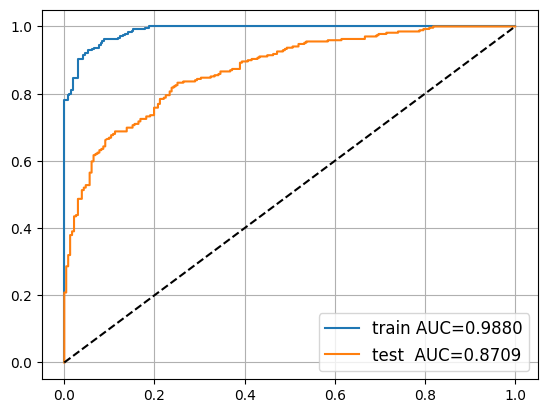

In [39]:
from sklearn.metrics import roc_auc_score, roc_curve

for name, X, y, model in [
    ('train', X_new_train_bow, y_train, tfidf_model),
    ('test ', X_new_test_bow, y_test, tfidf_model)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

test_accuracy = np.mean(tfidf_model.predict(X_new_test_bow) == y_test)
print(f"Model accuracy: {test_accuracy:.3f}")
assert test_accuracy > 0.76
print("Well done!")

### Solving it better: word vectors

Let's try another approach: instead of counting per-word frequencies, we shall map all words to pre-trained word vectors and average over them to get text features.

This should give us two key advantages: (1) we now have 10^2 features instead of 10^4 and (2) our model can generalize to word that are not in training dataset.

We begin with a standard approach with pre-trained word vectors. However, you may also try
* training embeddings from scratch on relevant (unlabeled) data
* multiplying word vectors by inverse word frequency in dataset (like tf-idf).
* concatenating several embeddings
    * call `gensim.downloader.info()['models'].keys()` to get a list of available models
* clusterizing words by their word-vectors and try bag of cluster_ids

__Note:__ loading pre-trained model may take a while. It's a perfect opportunity to refill your cup of tea/coffee and grab some extra cookies. Or binge-watch some tv series if you're slow on internet connection

In [ ]:
import gensim.downloader
embeddings = gensim.downloader.load("fasttext-wiki-news-subwords-300")

# If you're low on RAM or download speed, use "glove-wiki-gigaword-100" instead. Ignore all further asserts.

[==================================================] 100.0% 958.5/958.4MB downloaded


In [ ]:
embeddings.vectors.shape

(999999, 300)

In [ ]:
def vectorize_sum(comment):
    """
    implement a function that converts preprocessed comment to a sum of token vectors
    """
    embedding_dim = embeddings.vectors.shape[1]
    features = np.zeros([embedding_dim], dtype='float32')

    for word in comment.split():
      if word not in embeddings.key_to_index.keys():
        features += embeddings.get_mean_vector(word)
      else:
        features += embeddings.get_vector(word)

    return features

assert np.allclose(
    vectorize_sum("who cares anymore . they attack with impunity .")[::70],
    np.array([ 0.0108616 ,  0.0261663 ,  0.13855131, -0.18510573, -0.46380025])
)

In [ ]:
X_train_wv = np.stack([vectorize_sum(text) for text in texts_train])
X_test_wv = np.stack([vectorize_sum(text) for text in texts_test])

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


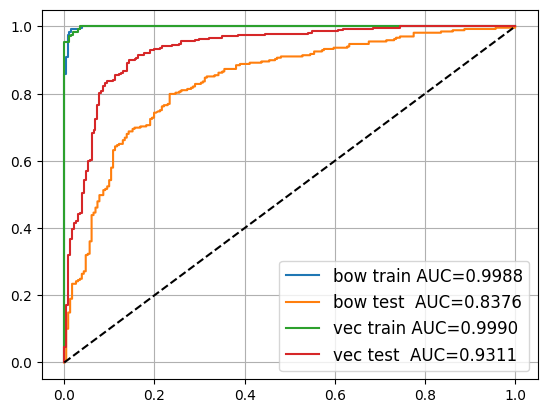

In [ ]:
wv_model = LogisticRegression().fit(X_train_wv, y_train)

for name, X, y, model in [
    ('bow train', X_train_bow, y_train, bow_model),
    ('bow test ', X_test_bow, y_test, bow_model),
    ('vec train', X_train_wv, y_train, wv_model),
    ('vec test ', X_test_wv, y_test, wv_model)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

assert roc_auc_score(y_test, wv_model.predict_proba(X_test_wv)[:, 1]) > 0.92, "something's wrong with your features"

In [ ]:
#vec_train_best = 0.9990
#vec_test_best = 0.9313

If everything went right, you've just managed to reduce misclassification rate by a factor of two.
This trick is very useful when you're dealing with small datasets. However, if you have hundreds of thousands of samples, there's a whole different range of methods for that. We'll get there in the second part.

# Few shot with setfit

In [40]:
!pip install setfit datasets -q

In [43]:
from setfit import SetFitModel
from datasets import Dataset

model = SetFitModel.from_pretrained("sentence-transformers/paraphrase-multilingual-mpnet-base-v2")

config.json:   0%|          | 0.00/723 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.13k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/402 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


In [44]:
data = pd.read_csv("comments.tsv", sep='\t')
data['sent_full'] = data['should_ban'].map({0: 'Positive', 1: 'Negative'})
data[50::200]

,should_ban,comment_text,sent_full
50,0,"""Those who're in advantageous positions are th...",Positive
250,1,Fartsalot56 says f**k you motherclucker!!,Negative
450,1,"Are you a fool? \n\nI am sorry, but you seem t...",Negative
650,1,I AM NOT A VANDAL!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!,Negative
850,0,Citing sources\n\nCheck out the Wikipedia:Citi...,Positive


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(data['comment_text'],
                                                    data['sent_full'],
                                                    test_size=0.2, random_state=42)

In [46]:
train_dataset = Dataset.from_pandas(data[['comment_text', 'sent_full']].reset_index(drop=True))
train_dataset

Dataset({
    features: ['comment_text', 'sent_full'],
    num_rows: 1000
})

In [49]:
new_dataset = train_dataset.train_test_split(test_size=0.2)
new_dataset

DatasetDict({
    train: Dataset({
        features: ['comment_text', 'sent_full'],
        num_rows: 800
    })
    test: Dataset({
        features: ['comment_text', 'sent_full'],
        num_rows: 200
    })
})

In [52]:
model = model.to('cuda')

In [53]:
from sentence_transformers.losses import CosineSimilarityLoss
from setfit import SetFitTrainer

trainer = SetFitTrainer(
    model=model,
    train_dataset=new_dataset['train'],
    eval_dataset=new_dataset['test'],
    loss_class=CosineSimilarityLoss,
    num_iterations=20,
    column_mapping={"comment_text": "text", "sent_full": "label"},
)

<ipython-input-53-1611dc32bdb3>:4: DeprecationWarning: `SetFitTrainer` has been deprecated and will be removed in v2.0.0 of SetFit. Please use `Trainer` instead.
  trainer = SetFitTrainer(
Applying column mapping to the training dataset
Applying column mapping to the evaluation dataset


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

In [54]:
trainer.train()

***** Running training *****
  Num unique pairs = 32000
  Batch size = 16
  Num epochs = 1
  Total optimization steps = 2000


Step,Training Loss


In [55]:
metrics = trainer.evaluate()
metrics

***** Running evaluation *****


{'accuracy': 0.935}

# BERT

In [ ]:
!pip install datasets stop-words transformers evaluate
!pip install accelerate -U

In [ ]:
data = pd.read_csv("comments.tsv", sep='\t')
data[50::200]

,should_ban,comment_text
50,0,"""Those who're in advantageous positions are th..."
250,1,Fartsalot56 says f**k you motherclucker!!
450,1,"Are you a fool? \n\nI am sorry, but you seem t..."
650,1,I AM NOT A VANDAL!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
850,0,Citing sources\n\nCheck out the Wikipedia:Citi...


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(data['comment_text'],
                                                    data['should_ban'],
                                                    test_size=0.2, random_state=42)

In [ ]:
import evaluate
import torch

In [ ]:
from stop_words import get_stop_words
import string
import re

stop_words = get_stop_words('en')

def clean_txt(text):
    text = str(text)
    text = text.lower()
    cleaned_text = re.sub(r'[*_]', '', text)
    cleaned_text = re.sub(r'\n', '', cleaned_text)
    cleaned_text = ' '.join([i for i in cleaned_text.split() if i not in stop_words]) # drop english stop words
    cleaned_text = cleaned_text.translate(str.maketrans('', '', string.punctuation)) # drop punctuation
    cleaned_text = re.sub(r'\d+', '', cleaned_text) # drop digits (optionally)
    #cleaned_text = ' '.join([word for word in cleaned_text.split() if len(word) > 2]) # drop short words (optionally)
    return cleaned_text

In [ ]:
x_train = x_train.apply(lambda x: clean_txt(x))
x_train[50::200]

82                    beware flying dicks fudging nigger
585    actingfrom now nobody change edit honor societ...
194                        signed moron  part understand
32     wikipedia finest want cry river build bridge g...
Name: comment_text, dtype: object

In [ ]:
x_test = x_test.apply(lambda x: clean_txt(x))
x_test[50::200]

570    get reality grip suck try responsible take you...
Name: comment_text, dtype: object

In [ ]:
from datasets import DatasetDict, Dataset

In [ ]:
train_dataset = Dataset.from_pandas(pd.concat((x_train, y_train), axis=1).reset_index(drop=True))
test_dataset = Dataset.from_pandas(pd.concat((x_test, y_test), axis=1).reset_index(drop=True))

print(train_dataset)
print(test_dataset)

Dataset({
    features: ['comment_text', 'should_ban'],
    num_rows: 800
})
Dataset({
    features: ['comment_text', 'should_ban'],
    num_rows: 200
})


In [ ]:
train_dataset = train_dataset.train_test_split(test_size=0.2)
train_dataset

DatasetDict({
    train: Dataset({
        features: ['comment_text', 'should_ban'],
        num_rows: 640
    })
    test: Dataset({
        features: ['comment_text', 'should_ban'],
        num_rows: 160
    })
})

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import DataCollatorWithPadding

model_name = 'FacebookAI/roberta-base'
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
def preprocess_function(examples):
    # we don't need padding here, because of DataCollatorWithPadding
    # we don't need return_tensors='pt', because Dataset
    # contain only lists, it changes only in the moment of using
    inputs = tokenizer(examples["comment_text"], max_length=512, truncation=True)
    inputs["labels"] = examples["should_ban"]

    return inputs

In [ ]:
tokenized_dataset = train_dataset.map(preprocess_function, batched=True,
                                      remove_columns=['comment_text', 'should_ban'])

Map:   0%|          | 0/640 [00:00<?, ? examples/s]

Map:   0%|          | 0/160 [00:00<?, ? examples/s]

In [ ]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 640
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 160
    })
})

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer,
                                        max_length=512,
                                        padding='max_length',
                                        return_tensors='pt')

In [ ]:
model

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [ ]:
from transformers import Trainer, TrainingArguments
from transformers import logging
logging.set_verbosity_debug()
#from transformers import get_linear_schedule_with_warmup

#def compute_metrics(eval_pred):
#    """
#    if you want some extraordinary metric istead of cross_entropy by default
#    """
#    predictions, labels = eval_pred
#    predictions = np.argmax(predictions, axis=1)
#    return {'accuracy': accuracy_score(labels, predictions)}

num_epochs = 5
batch_size = 5
num_training_examples = len(tokenized_dataset['train'])
num_training_steps = (num_training_examples // batch_size) * num_epochs  # num_train_epochs=5 and per_device_train_batch_size=4

training_args = TrainingArguments(
    output_dir='./model_output',
    num_train_epochs=num_epochs,
    evaluation_strategy='epoch',
    save_strategy='epoch',
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=2e-5,
    weight_decay=0.01,
    save_total_limit=3,
    load_best_model_at_end=True,
    #metric_for_best_model='accuracy', # needs to be capable with compute metrics return name (key)
    gradient_accumulation_steps=2, # gradient accumulation before updating the parameters of the model
    logging_steps=10,
)

#this is used by default in trainer, but if you want dirty hand work it's here:
#optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
#scheduler = get_linear_schedule_with_warmup(
#    optimizer=optimizer,
#    num_warmup_steps=300,
#    num_training_steps=num_training_steps
#)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['test'],
    tokenizer=tokenizer,
    data_collator=data_collator,
    #compute_metrics=compute_metrics,
    #optimizers=(optimizer, scheduler) # and here
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
trainer.train()

Currently training with a batch size of: 5
***** Running training *****
  Num examples = 640
  Num Epochs = 5
  Instantaneous batch size per device = 5
  Total train batch size (w. parallel, distributed & accumulation) = 10
  Gradient Accumulation steps = 2
  Total optimization steps = 320
  Number of trainable parameters = 124,647,170


Epoch,Training Loss,Validation Loss
1,0.369600,0.373246
2,0.313700,0.515943
3,0.090000,0.662470
4,0.002900,0.873627
5,0.032200,0.857022


***** Running Evaluation *****
  Num examples = 160
  Batch size = 5
Saving model checkpoint to ./model_output/checkpoint-64
Configuration saved in ./model_output/checkpoint-64/config.json
Model weights saved in ./model_output/checkpoint-64/model.safetensors
tokenizer config file saved in ./model_output/checkpoint-64/tokenizer_config.json
Special tokens file saved in ./model_output/checkpoint-64/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 160
  Batch size = 5
Saving model checkpoint to ./model_output/checkpoint-128
Configuration saved in ./model_output/checkpoint-128/config.json
Model weights saved in ./model_output/checkpoint-128/model.safetensors
tokenizer config file saved in ./model_output/checkpoint-128/tokenizer_config.json
Special tokens file saved in ./model_output/checkpoint-128/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 160
  Batch size = 5
Saving model checkpoint to ./model_output/checkpoint-192
Configuration saved in 

TrainOutput(global_step=320, training_loss=0.22751902476884425, metrics={'train_runtime': 373.8961, 'train_samples_per_second': 8.559, 'train_steps_per_second': 0.856, 'total_flos': 841955377152000.0, 'train_loss': 0.22751902476884425, 'epoch': 5.0})

### Test

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model_path = './model_output/checkpoint-3134'
tokenizer_path = './model_output/checkpoint-3134'

model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)

In [ ]:
from torch.utils.data import DataLoader
from tqdm import tqdm

test_encodings = tokenizer(test_dataset['comment_text'], truncation=True, padding=True, return_tensors="pt")
test_loader = DataLoader(test_encodings['should_ban'], batch_size=8)

model.eval()

predictions = []
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Predicting"):
        batch = batch.to(model.device)
        outputs = model(batch)

        probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)
        pred_ids = torch.argmax(probabilities, dim=-1)
        predictions.extend(pred_ids.cpu().numpy())